# Training & Testing

Set up of the data pipline, model, model training, and model testing.

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

2024-12-03 13:51:20.162374: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Parameters
train_path = 'local path'
test_path = 'local path'
image_size = (128, 128)
batch_size = 32

def get_labels(filename):
    """
    Extracts and processes a numerical label from the filename of an image.
    - The label is embedded in the filename as a number between underscores and a file extension.
    - If the label is 10, it is mapped to 0.

    Args:
    - filename: The filename (byte-encoded string) of the image.

    Returns:
    - An integer label extracted and processed from the filename.
    """
    filename_str = filename.decode("utf-8")
    label = int(filename_str.split('_')[1].split('.')[0])
    if label == 10:
        label = 0
    return np.int32(label)

def process_image(file_path):
    """
    Processes an image file for use in a machine learning pipeline.
    - Reads the image, decodes it, resizes it, normalizes pixel values, and assigns a label.

    Args:
    - file_path: Path to the image file.

    Returns:
    - img: The processed image tensor.
    - labels: A one-hot encoded label for the image.
    """
    # Load and decode the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    
    # Resize and normalize
    img = tf.image.resize(img, image_size)  # Resize the image
    img = Rescaling(scale=1./127.5, offset=-1)(img)  # Normalize
    
    # Extract filename and fetch labels
    filename = tf.strings.split(file_path, '/')[-1]  # Extract filename
    labels = tf.numpy_function(get_labels, [filename], tf.int32)
    labels.set_shape([])  # Ensure scalar shape for labels
    labels = tf.one_hot(labels, depth=10)  # Ensure fixed shape for labels
    
    return img, labels

# Data augmentation set-up
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def process_image_with_augmentation(file_path):
    """
    Processes an image file with data augmentation for use in a machine learning pipeline.
    - Reads and preprocesses the image and applies data augmentation techniques.

    Args:
    - file_path: Path to the image file.

    Returns:
    - img: The augmented and processed image tensor.
    - labels: The corresponding one-hot encoded label for the image.
    """
    img, labels = process_image(file_path)
    img = data_augmentation(img)  # Apply augmentation
    return img, labels

# File paths
train_file_paths = [os.path.join(train_path, fname) for fname in os.listdir(train_path) if fname.endswith('.png')][:30000]
test_file_paths = [os.path.join(test_path, fname) for fname in os.listdir(test_path) if fname.endswith('.png')]

# split training dataset into training and validation datasets
np.random.shuffle(train_file_paths)
split_index = int(0.8 * len(train_file_paths))
train_paths = train_file_paths[:split_index]
val_paths = train_file_paths[split_index:]

# Create training and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(process_image_with_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)
val_dataset = val_dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# create testing dataset
test_dataset = tf.data.Dataset.from_tensor_slices(test_file_paths)
test_dataset = test_dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# intialize model
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),      # Input layer for 128x128 grayscale images
    layers.Conv2D(32, (3, 3), activation='relu'),  # Convolutional layer
    layers.MaxPooling2D((2, 2)),         # Max-pooling layer
    layers.Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer
    layers.MaxPooling2D((2, 2)),         # Max-pooling layer
    layers.Flatten(),                    # Flatten for dense layers
    layers.Dense(128, activation='relu'), # Fully connected layer
    layers.Dense(10, activation='softmax') # Output layer for 10 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# set up early stopping mechanism
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,              # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore the best model weights
)


# Train the model
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 10,
    batch_size = 32,
    callbacks=[early_stopping]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,610 (28.20 MB)

 Trainable params: 7,393,610 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# save the model
model.save('full_model_1.keras')

In [ ]:
# Save the history to a JSON file
with open('training_history_1.json', 'w') as f:
    json.dump(history.history, f)

In [ ]:
# load the model
model = models.load_model("full_model_1.keras")

In [ ]:
# evaluate overall performance on the test data
model.evaluate(test_dataset)

767/767 ━━━━━━━━━━━━━━━━━━━━ 73s 94ms/step - accuracy: 0.6097 - loss: 1.4115


[1.390030026435852, 0.6119768023490906]

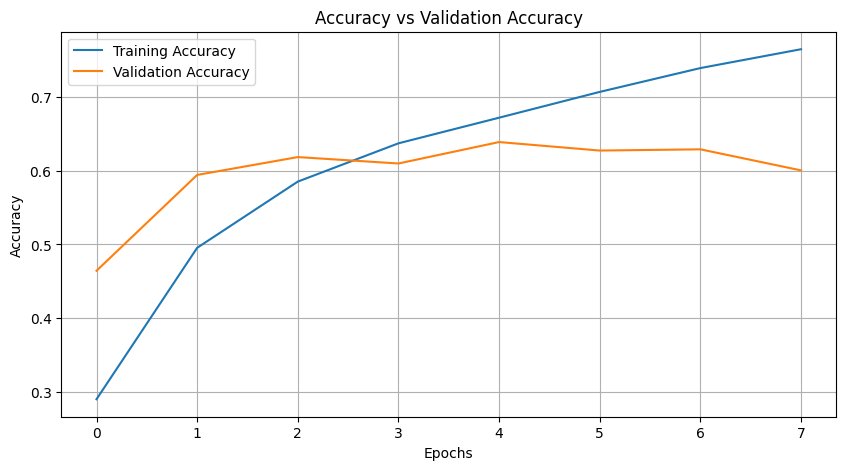

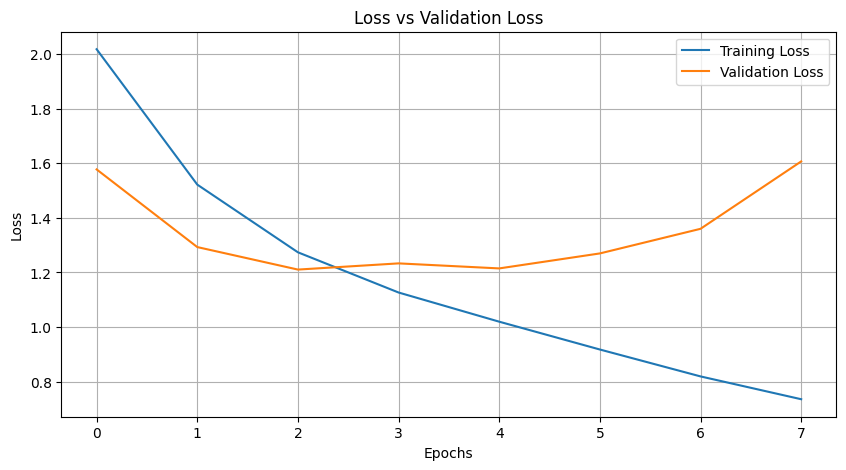

In [ ]:
# Load the history from the saved JSON file
with open('training_history_1.json', 'r') as f:
    history = json.load(f)

# Plot Accuracy vs Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_true = []
y_pred = []

# iterate through images and extract true class and make prediction
for images, labels in test_dataset:
    y_true.extend(np.argmax(labels, axis=1)) 
    y_pred.extend(np.argmax(model.predict(images), axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(10)])

print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━

2024-12-03 15:26:24.787803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


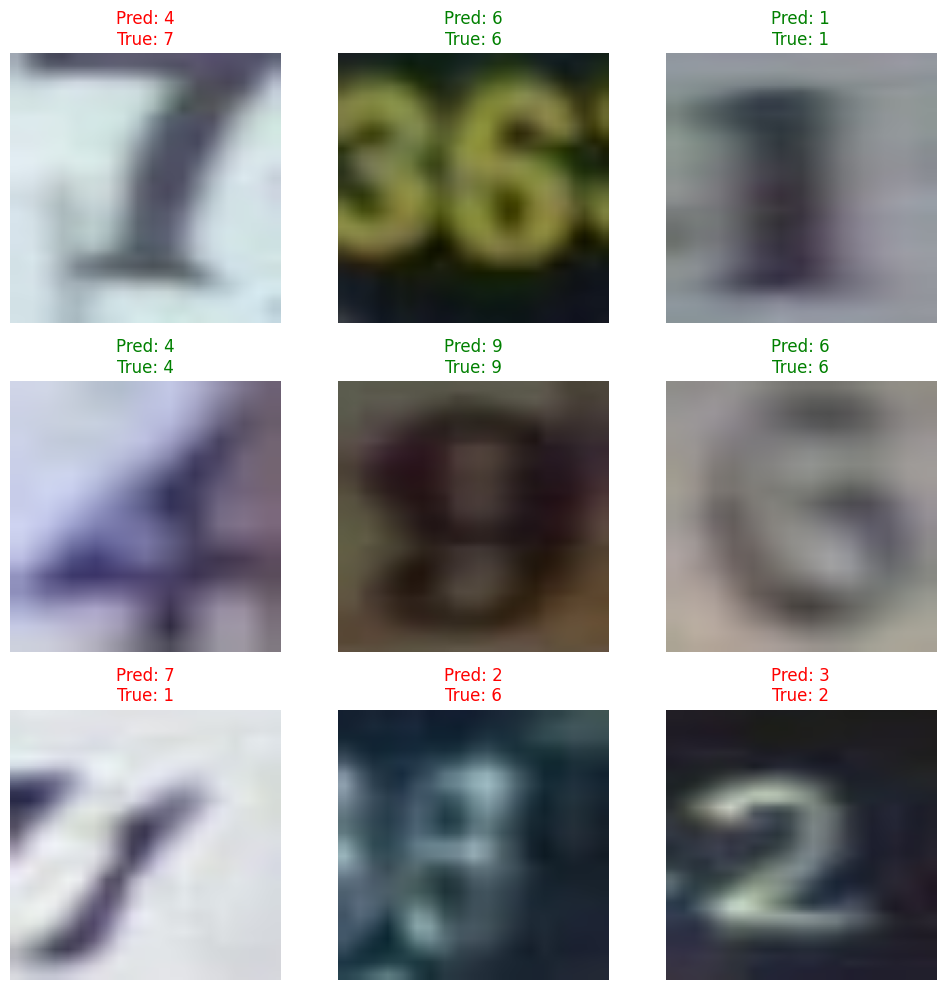

In [ ]:
# Get the first batch of images and labels
test_images, test_labels = next(iter(test_dataset))

# Make predictions and extract true classes
predictions = model.predict(test_images[:9]) 
predicted_classes = np.argmax(predictions, axis=1)  
true_classes = np.argmax(test_labels[:9], axis=1)  

# Create the 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Loop through the 9 images and display them
for i, ax in enumerate(axes.flat):
    # Display image
    ax.imshow((test_images[i] + 1) / 2)  # Undo normalization 
    ax.axis('off')  # Hide axes

    # Get predicted and true class labels
    predicted_class = predicted_classes[i]
    true_class = true_classes[i]

    # Set the text for the label
    label_color = 'green' if predicted_class == true_class else 'red'
    ax.set_title(f"Pred: {predicted_class}\nTrue: {true_class}", color=label_color, fontsize=12)

plt.tight_layout()
plt.show()
